In [2]:
import pandas as pd 
import json 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow
import numpy as np

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('NN_ovitraps')



<Experiment: artifact_location='mlflow-artifacts:/644241295842565038', creation_time=1729603256150, experiment_id='644241295842565038', last_update_time=1729603256150, lifecycle_stage='active', name='NN_ovitraps', tags={}>

In [3]:
model_type =  'regressor' # regressor or classifier or exponential_renato' 
use_trap_info = True # True or False
ntraps = 3 #int
lags = 3 #int
random_split = False # True or False
test_size = 0.2 # float [0,1].2
scale = False # True or False
learning_rate =1e-3 # float
batch_size = 64 # int
epochs = 1 # int



In [4]:
parameters = {
    'model_type' : model_type,  
    'use_trap_info' : use_trap_info, 
    'ntraps' : ntraps, 
    'lags' : lags, 
    'random_split' : random_split, 
    'test_size' : test_size, 
    'scale' : scale, 
    'learning_rate' : learning_rate, 
    'batch_size' : batch_size, 
    'epochs' : epochs 

}

mt = parameters['model_type']
# Construct the filter to check model version
filter_string = " and ".join([f"params.{key} = '{value}'" for key, value in parameters.items()])

# Search for existing runs using the constructed filter string
runs_list = mlflow.search_runs(filter_string=filter_string)
size = len(runs_list)

In [5]:
# Retrieve the logged dictionaries from artifacts
test_history_list = []
train_history_list = []
output_list = []
version_list = []

for _,run in (runs_list.iterrows()):
    run_id = run['run_id']

    test_history_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path='test_history.json')
    with open(test_history_path, 'r') as f:
        test_history = json.load(f)
    test_history_list.append(test_history)

    train_history_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path='train_history.json')
    with open(train_history_path, 'r') as f:
        train_history = json.load(f)
    train_history_list.append(train_history)

    output_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path='output.json')
    with open(output_path, 'r') as f:
        output = json.load(f)
    output_list.append(output)
    

    version_list.append(int(run['tags.version']))

    

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Plots

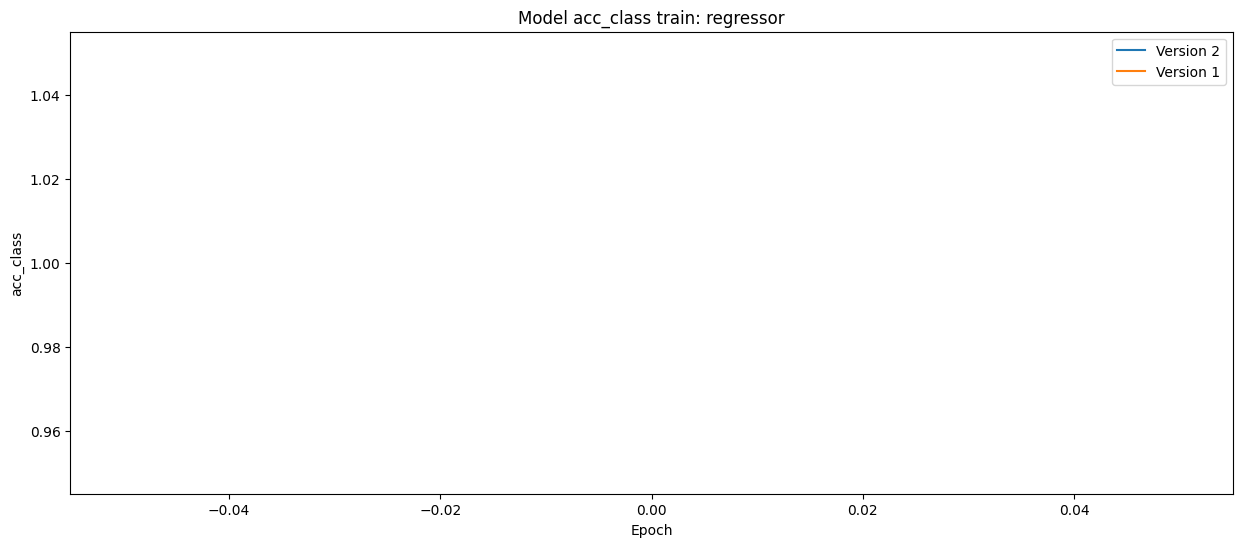

In [6]:
variable_plot = 'acc_class' 
test_train = 'train'

def plot_results(variable_plot, test_train):
    """
    variable_plot = ['total_loss', 'loss_class', 'loss_reg', 'acc_class', 'acc_reg', 'error_reg']
    
    """
    if test_train == 'train':
        list_plot = train_history_list
    elif test_train == 'test':
        list_plot = test_history_list    

    plt.figure(figsize=(15, 6))  
    for i in range(size):   
        y = list(map((lambda x: x/100 if x > 1 else x),list_plot[i][variable_plot]))
        x = range(1, epochs+1)
        plt.plot(y, x, label='Version {}'.format(version_list[i]))
        plt.xlabel('Epoch')
        plt.ylabel(f'{variable_plot}')
        plt.legend()
        plt.title(f'Model {variable_plot} {test_train}: {mt}')

    plt.show()

plot_results(variable_plot, test_train)

In [11]:
test_history_list[0].keys()

dict_keys(['total_loss', 'loss_class', 'loss_reg', 'acc_class', 'acc_reg', 'error_reg'])

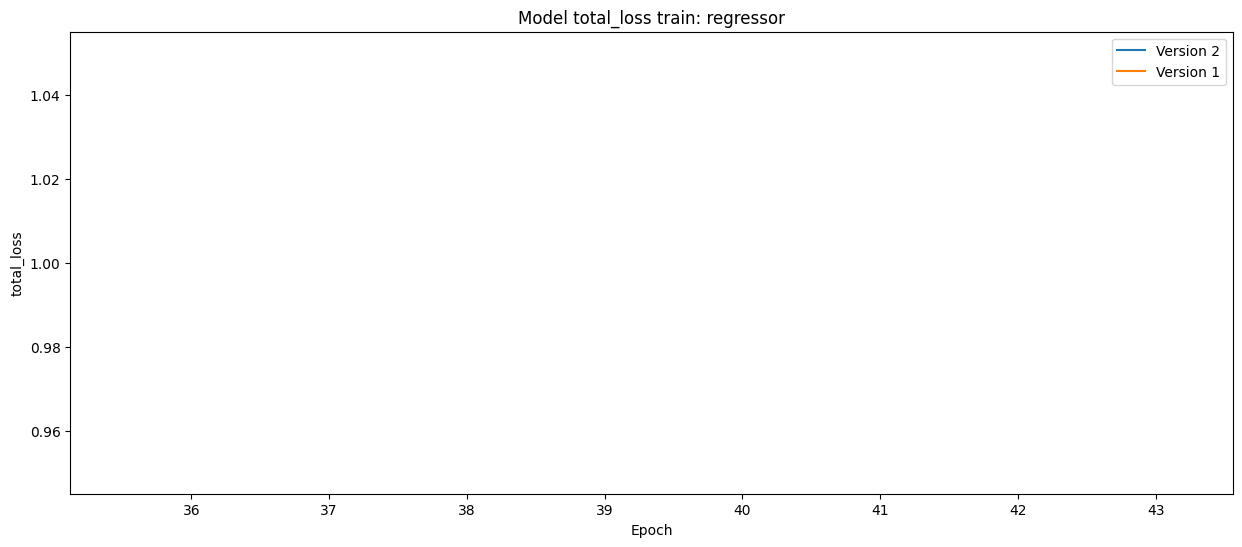

In [12]:
variable_plot = 'total_loss' 
plot_results(variable_plot, test_train)


Output analysis

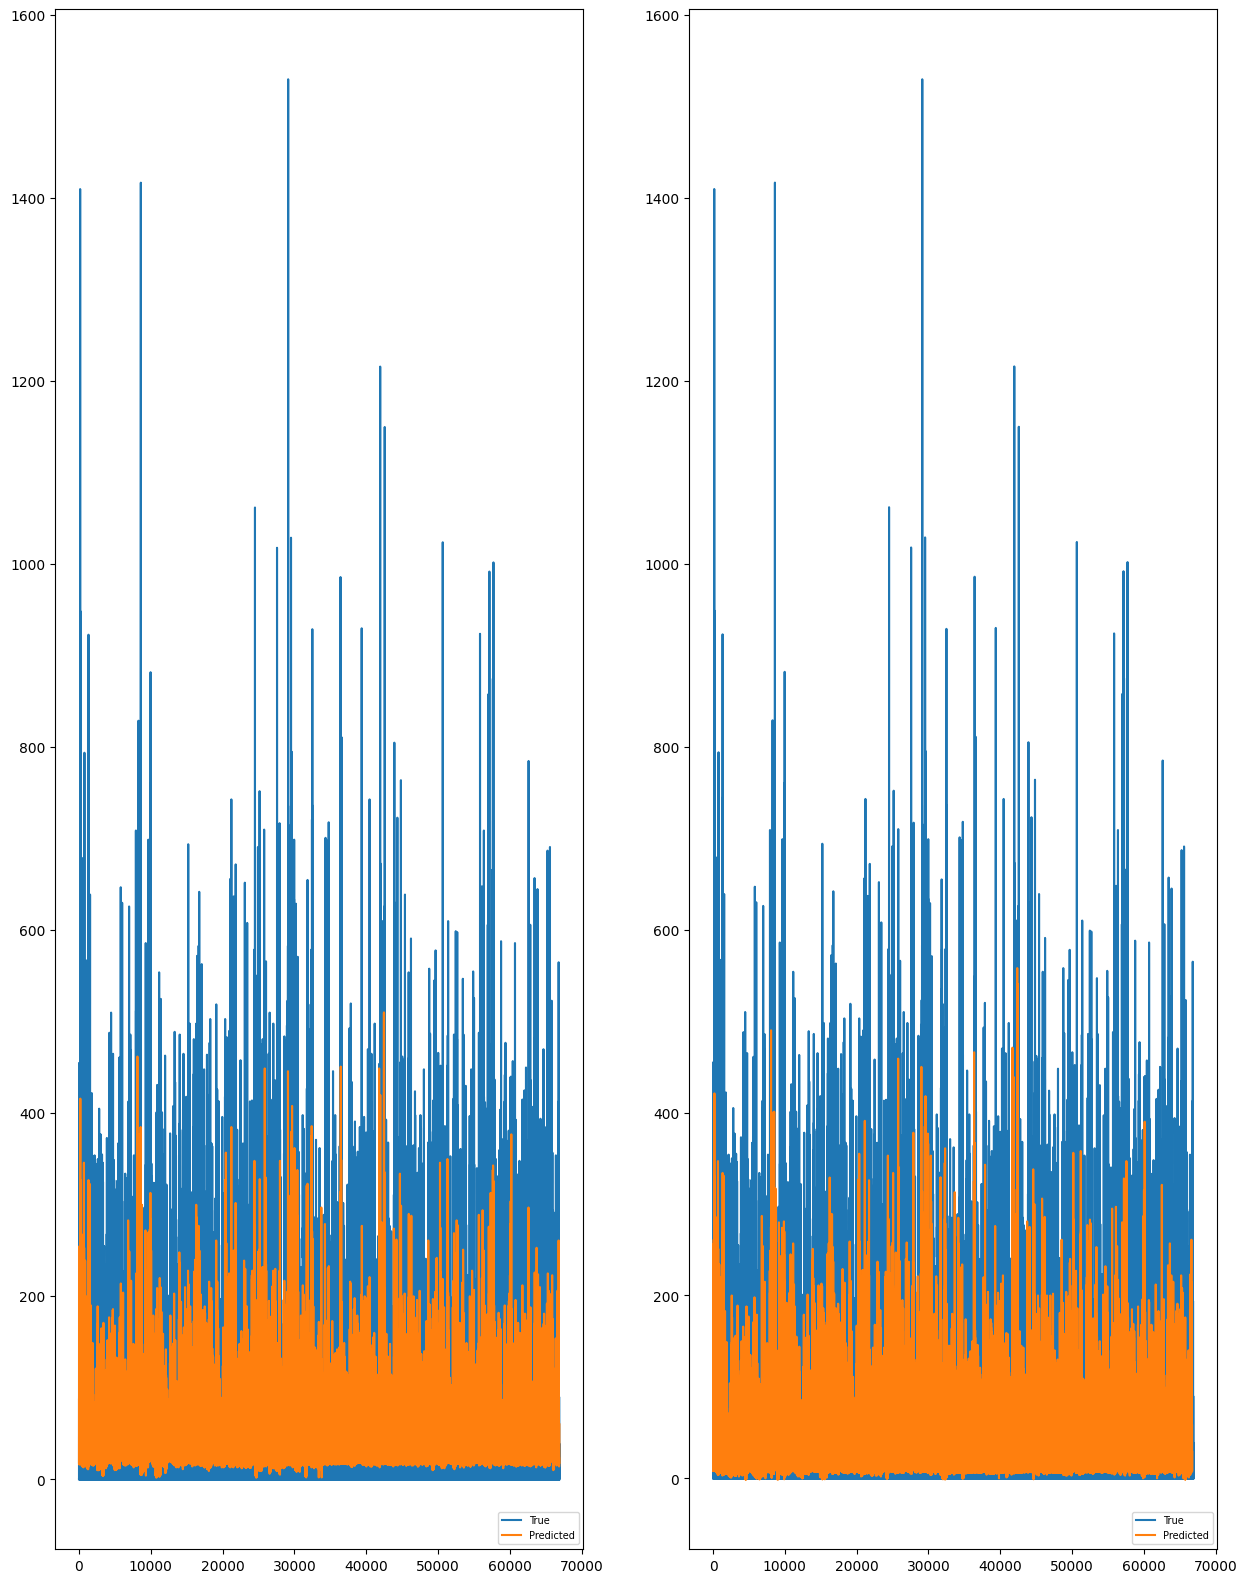

In [63]:
fig, ax = plt.subplots(size//2, 2, figsize=(15, 20))  # Create a figure and an axes
ax = np.atleast_2d(ax)
j = 1 #plot index
count = 0

for i in range(size):
    j = abs(j-1) # 0 or 1
    if mt == 'regressor':
        threshold_max = 200000
        threshold_min = -1
        filtered_ytest = [y for y in output_list[i]['ytest'] if y <= threshold_max and y >= threshold_min]
        filtered_yhat = [y for y in output_list[i]['yhat'] if y <= threshold_max and y >= threshold_min]

        
        ax[count,j].plot(filtered_ytest, label='True')
        ax[count,j].plot(filtered_yhat, label='Predicted')
    if mt == 'classifier':
        cm = confusion_matrix(output_list[i]['ytest'], output_list[i]['yhat'])
        cm_flat = cm.flatten()

        # Labels for the pie chart
        labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
        colors = ['lightgreen', 'lightcoral', 'lightskyblue', 'gold']
        ax[count,j].pie(cm_flat, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)

    ax[count,j].legend(loc="lower right", prop={'size': 7})
    count += j

    
    